In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.factorization import KMeans
from sklearn.model_selection import StratifiedShuffleSplit

run=0

## Generating some data

I wanted to generate some toy data to exemplify a situation where multiple prototypes per class are necessary.
Imagine that we are in the few shot scenario, and our embedding network has output some embeded data points. However, the embeding was not able to fully disentangle the classes, so that we still have disjoint components for each class.

Below I generate the said data:

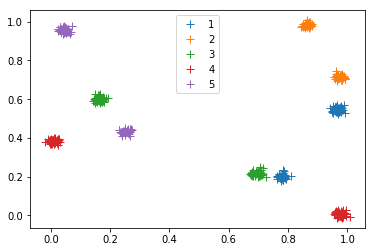

In [6]:
# For N=2, try seed 2 for an almost complicated case, seed 4 for a tough one, seed 9 for an easy one
def gen_data(extra_samples=100,N=2,K=5,comp=2, random_seed=None):
    # K shot
    # N is Num of classes
    # m is number of samples
    m = (K+extra_samples)*N
    # comp is Number of components per clas

    if random_seed is not None:
        np.random.seed(4)
    # Sample a training 2D dataset

    # Class means are sampled from a U(0,1). I want data to be positive 
    # because it is suposed to come from a previous ReLU activation.
    Y_mean = np.random.rand(comp*N, 2)
    Y = np.random.randint(low=0, high=comp*N, size=m)
    # Choose std
    std = 0.01
    X = std*np.random.randn(m, 2)
    for k in range(comp*N):
        points = np.ix_(Y==k)
        X[points,:] += Y_mean[k, :]
    Y = np.mod(Y, N)
    return X, Y
N = 5
K = 5
X, Y = gen_data(N=N, random_seed=4)
m = X.shape[0]
# plot
plt.figure()
for k in range(N):
    points = np.ix_(Y==k)
    plt.plot(X[points,0].squeeze(),X[points,1].squeeze(), label=str(k+1), 
             marker='+', linestyle='', ms=8)
plt.legend(loc='best')
axis = plt.axis()

## Basic prototype approach
Given this data, i'll calculate class prototypes (which obviously will yield a poor classifier) 

In [7]:
def get_split(X,Y,n_splits,m,N,K):
    skf = StratifiedShuffleSplit(
        train_size=K*N, test_size=m-K*N, n_splits=1)
    for support, test in skf.split(X, Y):
        x, y = X[support,:], Y[support]
        xt, yt = X[test,:], Y[test]
        yield (x,y, xt,yt)

split = get_split(X,Y,3,m,N,K)
x,y,xt,yt  = next(split)


miss 187 of 500 err 37.4 %


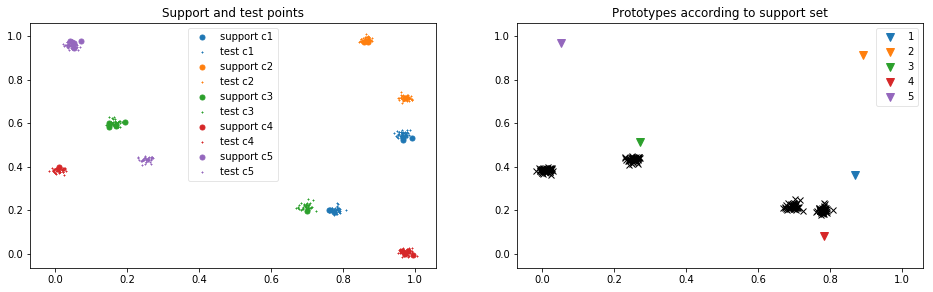

In [8]:


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(-x) / np.sum(np.exp(-x), axis=0)

def dist(x1, x2):
    return np.linalg.norm(x1-x2, ord=2)

skf = StratifiedShuffleSplit(train_size=K*N, test_size=m-K*N, n_splits=1)
for support, test in skf.split(X, Y):
    x, y = X[support,:], Y[support]
    xt, yt = X[test,:], Y[test]
    prototypes = []
    prototype_class = []
    plt.figure(1, figsize=(16,4.5))
    for k in range(N):
        proto = x[np.ix_(y==k)].mean(axis=0)
        prototypes.append(proto)
        prototype_class.append(k)
        points = np.ix_(Y==k)
        plt.subplot(1,2,2)
        lines = plt.plot(proto[0].squeeze(),proto[1].squeeze(), label=str(k+1), 
                 marker='v', linestyle='', ms=8)
        plt.subplot(1,2,1)
        lines = plt.plot(x[np.ix_(y==k),0].squeeze(),x[np.ix_(y==k),1].squeeze(), 
                         label='support c' + str(k+1), 
                         marker='o', linestyle='', ms=5)
        plt.plot(xt[np.ix_(yt==k),0].squeeze(),xt[np.ix_(yt==k),1].squeeze(), 
                 label='test c' + str(k+1), 
                 marker='+', linestyle='', ms=2, color=lines[0].get_color())
        
    plt.subplot(1,2,1)
    plt.axis(axis)
    plt.legend(loc='best', framealpha=0.5)
    plt.title('Support and test points')
    plt.subplot(1,2,2)
    plt.axis(axis)
    plt.title('Prototypes according to support set')
    plt.legend(loc='best', framealpha=0.5)
    
    ##
    
    miss = 0
    for query, label in zip(xt, yt):        
        logit = softmax(np.array([dist(query, p) for p in prototypes]))
        pred = prototype_class[np.argmax(logit)]
        if pred!=label: 
            miss +=1
            plt.subplot(1,2,2)
            plt.plot(query[0], query[1], marker='x', color='k', label='miss')
    print('miss', miss, 'of', len(yt), 'err', (100*miss)/len(yt), '%')


## Mutiple flexible protoypes?
Now let's see if I can work this out with multiple implicit prototypes. 

Bellow I implement an alternate optimization doing kmeans to define prototypes. Then the prototypes are used in a nearest-neighbor fashion for classification.

As prototype activation for each sample i and prototype j , I did:
$$Ap_{ij} = softmax(-distance(x_i, p_j))$$

Here the first "layer" is not based on an inner product anymore, but on an euclidean distance matching.

Following, I have a linear classifier
$$Ac=Ap*Wc.T$$
$$logits=softmax(Ac)$$

Here I use the cross-entropy loss between logits and predictions.

I have the choice of fixing or not the prototypes in Wp when optimizeing the cross entropy loss. That way I have a simple linear classifier over the prototypes, and I will never solve non-linearly separable cases.

Below the code for classification


## Cross entropy over both layers - from latex notes

In [9]:
def clusterNclassif(x, y, protos, input_proto_idx, num_classes, num_proto, learning_rate, 
                    decay_steps=0.0, temperature=1.0,
                    l1=0.03, one_proto=100, positive_wc=100, random_seed=0, scope=None):
    
    with tf.variable_scope(scope) as scope:
        x_emb = x
       
        # Defining q(x) = prob(p|x) = softmax over -distance to prototypes
        proto_list = tf.unstack(protos, axis=0)
        distance_protos = tf.stack([tf.reduce_sum(tf.squared_difference(x_emb, pi), axis=-1)
                                    for pi in proto_list], axis=-1)
        
        act_proto = slim.softmax(-distance_protos, scope="softmax_act_proto")
        
        batch_size, dim = tuple(x_emb.get_shape().as_list())
        # defining C_l(x) = prob(l|p)prob(p|x) 
        # classification layer over q(x) : cl(x) = softmax (q(x) Wc)
        reg = slim.l1_regularizer(l1)
        logits = slim.fully_connected(
            act_proto, num_classes, activation_fn=None,
            weights_initializer=tf.random_uniform_initializer(0, 1),
            weights_regularizer=reg,
            variables_collections=['Wc'],
            scope='classes')
        
        predictions = slim.softmax(logits, scope='predictions')
        
        labels = tf.argmax(predictions, axis=-1, output_type=tf.int32, name='labels') 
        
        y_one_hot = slim.one_hot_encoding(y, num_classes)
        
        class_loss = tf.losses.softmax_cross_entropy(y_one_hot, logits, T, scope='xentropy')
        
        #tf.losses.add_loss(class_loss)
        slim.summaries.add_scalar_summary(class_loss)   
        
        accuracy = slim.metrics.accuracy(labels, y)
        slim.summaries.add_scalar_summary(accuracy)

        scope.reuse_variables()

        
        # Add penalty to force at least one proto per class
        Wc = tf.get_variable('classes/weights')
        if one_proto:
            Wc_proto_sum = tf.reduce_sum(Wc, axis=0)
            one_proto_penalty = tf.losses.absolute_difference(
                Wc_proto_sum, tf.ones_like(Wc_proto_sum), weights=one_proto, scope='one_proto_penalty')
            slim.summaries.add_scalar_summary(one_proto_penalty)
            tf.losses.add_loss(one_proto_penalty)
        # Add penalty to force positive Wc
        if positive_wc:
            positive_wc_penalty = tf.multiply(positive_wc, tf.reduce_sum(-Wc, axis=[0,1]), 
                                              name='positive_wc_penalty')
            tf.losses.add_loss(positive_wc_penalty)
    if decay_steps != 0:
        learning_rate = tf.train.exponential_decay(
            learning_rate, tf.train.get_or_create_global_step(),
            decay_rate=0.5, decay_steps=1e3, staircase=True)
        slim.summaries.add_scalar_summary(learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        with tf.variable_scope('classification_optimizer'):
            trainable_vars = slim.get_trainable_variables(scope=scope)
            loss = tf.losses.get_total_loss()
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(
                loss, var_list=trainable_vars,
                global_step=tf.train.get_or_create_global_step())

        
        return {'classif_train_op': train_op,
                'predictions' : predictions,
                'labels': labels}
"""
-----PARAMETERS----
"""
num_proto = 5*N
l1 = 3e-4 # sensitive around 1e-4, 5e-4 is already too much

one_proto = 0.0
positive_wc = 0.0
T = 1

learning_rate = 0.005
epochs = int(5e4)
decay_steps = 0.0

tf.reset_default_graph()
tf.set_random_seed(0)
sess = tf.InteractiveSession()

x_tensor, y_tensor = tf.convert_to_tensor(x, tf.float32), tf.convert_to_tensor(y, tf.int32)

with tf.variable_scope('clustering'):
    tfkmeans = KMeans(inputs=x_tensor, num_clusters=num_proto, initial_clusters='kmeans_plus_plus', 
              # these down are default values, copied them here to know them
              distance_metric='squared_euclidean',
              use_mini_batch=False, mini_batch_steps_per_iteration=1, 
              kmeans_plus_plus_num_retries=2)


    (cluster_all_scores, cluster_idx, scores, 
     cluster_centers_initialized,
     cluster_init_op, cluster_training_op) = tfkmeans.training_graph()

    clusters = slim.get_variables_by_suffix('clusters:0')[0]

protos = tf.reshape(clusters, [num_proto, x.shape[1]])
slim.summaries.add_histogram_summary(protos, 'protos')
slim.summaries.add_image_summary(tf.reshape(protos, [1,x.shape[1], num_proto,1]), 'Wp')
input_proto_idx = tf.reshape(cluster_idx[0], [x.shape[0]])
slim.summaries.add_histogram_summary(input_proto_idx, 'input_proto_idx')

out = clusterNclassif(
    x_tensor, y_tensor, protos, input_proto_idx, 
    num_classes=N, num_proto=num_proto,
    learning_rate=learning_rate, decay_steps=decay_steps, temperature=T,
    l1=l1, one_proto=one_proto, positive_wc=positive_wc, scope='classif')

all_summaries = tf.summary.merge_all()

summary_writer = tf.summary.FileWriter('/tmp/proto/clusterNclassif%d'%run, tf.get_default_graph())
sess.run(tf.global_variables_initializer())
run += 1
sess.run([cluster_init_op])
for i in range(0, epochs): 
    sess.run(cluster_training_op)
    _, summary = sess.run([out['classif_train_op'], all_summaries])
    summary_writer.add_summary(summary, i)

print('RUN OK', run-1)

RUN OK 1


In [17]:
G = tf.get_default_graph()
sess.run(protos)
sum(sess.run(out['labels'])==y)
G.get_operations()
G.get_collection(tf.GraphKeys.INIT_OP)

[]

acc 0.65
[ True False False  True  True  True  True  True  True  True  True  True
 False False  True False False  True False  True]
[[ 0.77621992  0.17475594]
 [ 0.17493438  0.5937971 ]
 [ 0.69162311  0.20655292]
 [ 0.15624872  0.57307942]
 [ 0.96760041  0.54293458]
 [ 0.68031067  0.21890637]
 [ 0.95648895  0.53972366]]
[[  3.75603828e+01  -2.62683723e-04   1.45571365e-04  -6.93544629e-04]
 [ -1.63455624e-02   2.58347165e-04   7.02213123e-03  -1.85477966e-03]
 [ -5.78776759e-04   1.31891575e-05  -9.18620557e-04   3.08550312e-04]
 [  6.79233694e-04   8.65991972e-03  -3.80025152e-03  -4.47715080e-04]
 [ -4.58063208e-04   2.37819535e-04   2.54408951e-04   6.44907635e-03]
 [ -1.02713204e-03   1.07971570e-02  -1.04439002e-03   6.84235769e-04]
 [ -8.76802369e-05  -1.34794414e-02  -3.91403586e-03   1.47077316e+02]
 [ -1.80608872e-03   9.68078748e-05   5.33640035e-04  -5.53799095e-04]
 [  2.07691963e-04   4.07132693e-02  -1.49792526e-04  -1.45515427e-04]
 [  1.06030959e-03  -5.30657425e+01  -2

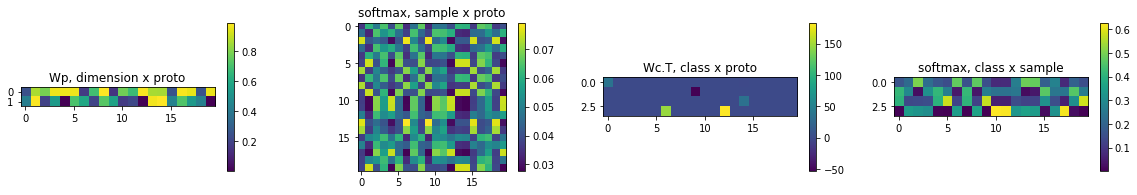

In [15]:
G = tf.get_default_graph() 
labels = sess.run(out['labels'])
print('acc', np.mean(labels==y))
softmax_act_proto = sess.run(G.get_tensor_by_name('classif/softmax_act_proto/Softmax:0'))
with tf.variable_scope('classif', reuse=True):
    Wc = sess.run(tf.get_variable('classes/weights'))
predictions = sess.run(out['predictions'])

dim_proto = sess.run(protos).T

plt.figure(figsize=(20,6))
plt.subplot( 2, 4, 1)
plt.imshow(dim_proto, interpolation='none', cmap='viridis')
plt.title('Wp, dimension x proto')
plt.colorbar()
plt.subplot( 2, 4, 2)
plt.imshow(softmax_act_proto, interpolation='none', cmap='viridis')
plt.title('softmax, sample x proto')
plt.colorbar()
plt.subplot( 2, 4,3)
plt.imshow(Wc.T, interpolation='none', cmap='viridis')
plt.title('Wc.T, class x proto')
plt.colorbar()
plt.subplot( 2, 4, 4)
plt.imshow(predictions.T, interpolation='none', cmap='viridis')
plt.title('softmax, class x sample')
plt.colorbar()
print(y==labels)
print(x[y!=labels])
print(Wc)

[0 2 3 1 3 1 3 2 1 3 1 2 3 2 2 0 1 1 0 3]


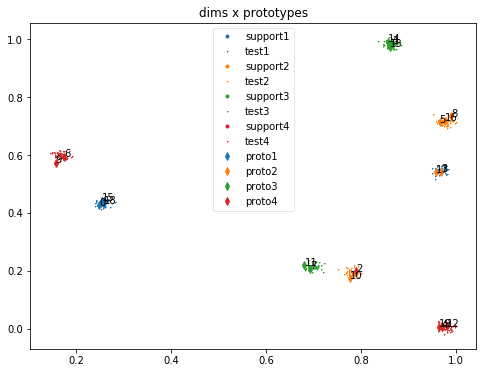

In [16]:
proto_class_label = np.argmax(Wc, axis=1)
print(proto_class_label)
plt.figure(figsize=(8,6))
plt.title('dims x prototypes')
colors=[]
for k in range(N):
    lines = plt.plot(x[np.ix_(y==k),0].squeeze(),x[np.ix_(y==k),1].squeeze(), label='support'+str(k+1), 
                 marker='o',  linestyle='', ms=3)
    plt.plot(xt[np.ix_(yt==k),0].squeeze(),xt[np.ix_(yt==k),1].squeeze(), label='test'+str(k+1), 
                 marker='+', linestyle='', ms=1, color=lines[0].get_color())
    colors.append(lines[0].get_color())
for k in range(N):
    points = dim_proto[:, np.ix_(proto_class_label==k)]
    p_ix = np.ix_(proto_class_label==k)
    plt.plot(points[0, :].squeeze(), points[1,:].squeeze(), marker='d',
             linewidth=0, label='proto'+str(k+1), color=colors[k], ms=5)
    for p, p_ix in zip(points.T,p_ix[0]):
        plt.annotate(xy=p[0,:], s=str(p_ix))
plt.legend(loc='best', framealpha=0.5)

* Forcing sum one or positivity in Wc makes it harder to learn, can't get good perf on training.
* overdoing l1 is also hindering learning.
* with no penalties and very low l1 I can get to overfit the training set, but weights are really high (really overfitting, but in this case it is fine).
* given the few-shot learning scenario maybe it is ok for this final layer to overfit since that's all evidence we have?
* for 3 classes L1 actually helped, I raised it a bit and got to overfit training. Before one of the prototypes was being misclassified.
* trying with one extra prototype, it got associated to a cluster
* as number of classes and prototypes raise L1 needs to be adjusted
* trying 5x the number of needed prototypes: some misclassification but they still go to some cluster.

## Lets sytematically test some params

## Getting kmeans to work via loss minimization in TF

The first cell performs k-means with scikit-learn's impelmentation, intended as a sanity check.

The second cell has the TF one.

I could get it decently working. Of course, since it is k-means, some times poor initialization leads to poor convergence. If you run the cells bellow with different seeds, you will see that sometimes the centroids (red dots)  converge to poor locations.

Current initialization consists in randomly picking input points.

[[ 0.70097564  0.20281445]
 [ 0.96562458  0.55193032]
 [ 0.98109375  0.0147312 ]
 [ 0.98300853  0.71115356]] [343 489 512 366] convergence 17


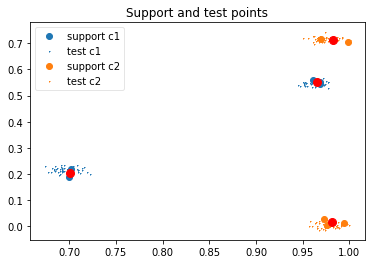

In [111]:
from sklearn.cluster import MiniBatchKMeans
cluster = MiniBatchKMeans(n_clusters=2*N, init='k-means++', random_state=0)

cluster.fit(x)
print(cluster.cluster_centers_, cluster.counts_, 
      'convergence', cluster.n_iter_)

plt.figure()

for k in range(N):
    lines = plt.plot(x[np.ix_(y==k),0].squeeze(),x[np.ix_(y==k),1].squeeze(), 
                     label='support c' + str(k+1), 
                     marker='o', linestyle='', ms=6)
    plt.plot(xt[np.ix_(yt==k),0].squeeze(),xt[np.ix_(yt==k),1].squeeze(), 
             label='test c' + str(k+1), 
             marker='+', linestyle='', ms=1, color=lines[0].get_color())
plt.plot(cluster.cluster_centers_[:,0], cluster.cluster_centers_[:,1], 
         marker='o', ms=8, linewidth=0, color='r')

plt.legend(loc='best', framealpha=0.5)
plt.title('Support and test points')

### Notes on TF variational implementation
* My kmeans model has Wp, a matrix which rows correspond to prototype coordinates
* Wp is initialized to random points taken from the batch x.
* the squared distance from all points in x to all prototypes in Wp is calculated, defining a distance matrix: $$distanceToProtos_{ij}=d_{ij}=||x_i-p_j||^2$$
* the minimum distance-to-prototype for every data point in batch comes from taking the minimum over the distance matrix for each row
 $$distanceToWinningProto_i = \min_j d_{ij}$$
 
* kmeans loss is to  minimize the sum of the square distances to the assigned prototypes. since the minimal distances already correspond to the assigned, prototypes, the loss is:
$$\sum_{i<N}distanceToWinningProto_i = \sum_{i<N}\min_j d_{ij}=  \sum_{i<N} \min_{p_j} ||x_i-p_j||^2 $$ where N is the number of samples in the batch x.

OK
[[ 0.7019859   0.21736762]
 [ 0.97474927  0.61120754]
 [ 0.98115617  0.01417843]
 [ 0.69997126  0.18834589]]


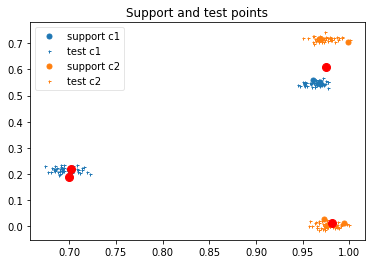

In [112]:
from collections import defaultdict

def kmeans(x, num_proto, learning_rate, scope=None):    
    with tf.variable_scope(scope) as scope:
        x_emb = x
        batch_size, dim = tuple(x_emb.get_shape().as_list())
        Wp_init = tf.transpose(tf.random_crop(tf.random_shuffle(x_tensor), size=[num_proto, dim]))
        Wp = tf.get_variable('prototypes', trainable=True, initializer=Wp_init)
        slim.summaries.add_image_summary(tf.reshape(Wp, [1,dim, num_proto,1]), 'Wp')
        Wp_list = tf.unstack(Wp, axis=-1)
        # euclidean distance to protos
        distance_protos = tf.stack([tf.reduce_sum(tf.squared_difference(x, pi), axis=-1)
                                    for pi in Wp_list], axis=-1)
        
        # distance to winning proto
        sqdistance2proto = tf.reduce_min(distance_protos, axis=1)  # shape n_samples x 1
        # compute clustering loss
        clustering_loss = tf.reduce_sum(sqdistance2proto)
        slim.summaries.add_scalar_summary(clustering_loss, 'clustering_loss')
        
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        with tf.variable_scope('clustering_optimizer'):
            train = tf.train.AdamOptimizer(learning_rate).minimize(
                clustering_loss, var_list=slim.get_trainable_variables(scope=scope),
                global_step=tf.train.get_or_create_global_step())
        
    return {'train_op' : train,
            'loss': clustering_loss,
            'prototypes': Wp,
            'distances': distance_protos}
    
tf.reset_default_graph()
tf.set_random_seed(0)
sess = tf.InteractiveSession()

x_tensor, y_tensor = tf.convert_to_tensor(x, tf.float32), tf.convert_to_tensor(y, tf.int32)

output = kmeans(x_tensor, num_proto=2*N, learning_rate=0.01, scope='model')

all_summaries = tf.summary.merge_all()

summary_writer = tf.summary.FileWriter('/tmp/proto/clustering%d'%run, tf.get_default_graph())
sess.run(tf.global_variables_initializer())
run += 1
for i in range(0, 50):
    _, summary = sess.run([output['train_op'], all_summaries])
    summary_writer.add_summary(summary, i)

print('OK')

with tf.variable_scope('model', reuse=True):
    Wp = sess.run(tf.get_variable('prototypes'))
    
print(Wp.T)
plt.figure()
for k in range(N):
    lines = plt.plot(x[np.ix_(y==k),0].squeeze(),x[np.ix_(y==k),1].squeeze(), 
                     label='support c' + str(k+1), 
                     marker='o', linestyle='', ms=5)
    plt.plot(xt[np.ix_(yt==k),0].squeeze(),xt[np.ix_(yt==k),1].squeeze(), 
             label='test c' + str(k+1), 
             marker='+', linestyle='', ms=3, color=lines[0].get_color())
plt.plot(Wp[0,:], Wp[1,:], 
         marker='o', ms=8, linewidth=0, color='r')

plt.legend(loc='best', framealpha=0.5)
plt.title('Support and test points')

## Kmeans class from TF.contrib.factorization

OK
graph variables
[<tf.Variable 'clusters:0' shape=<unknown> dtype=float32_ref>, <tf.Variable 'initialized:0' shape=() dtype=bool_ref>]
[[ 0.96943659  0.55000263]
 [ 0.97964919  0.00746379]
 [ 0.70478356  0.22109585]
 [ 0.96666974  0.71833026]]
(array([1, 3, 0, 3, 0, 2, 3, 2, 0, 1]),)


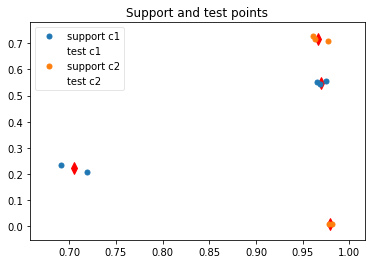

In [150]:


tf.reset_default_graph()
sess = tf.InteractiveSession()

x_tensor, y_tensor = tf.convert_to_tensor(x, tf.float32), tf.convert_to_tensor(y, tf.int32)


tfkmeans = KMeans(inputs=x_tensor, num_clusters=2*N, initial_clusters='kmeans_plus_plus', 
                  # these down are default values, copied them here to know them
                  distance_metric='squared_euclidean',
                  use_mini_batch=False, mini_batch_steps_per_iteration=1, 
                  random_seed=0, kmeans_plus_plus_num_retries=2)

"""
Method training_graph() returns:
  A tuple consisting of:
  all_scores: A matrix (or list of matrices) of dimensions (num_input,
    num_clusters) where the value is the distance of an input vector and a
    cluster center.
  cluster_idx: A vector (or list of vectors). Each element in the vector
    corresponds to an input row in 'inp' and specifies the cluster id
    corresponding to the input.
  scores: Similar to cluster_idx but specifies the distance to the
    assigned cluster instead.
  cluster_centers_initialized: scalar indicating whether clusters have been
    initialized.
  init_op: an op to initialize the clusters.
  training_op: an op that runs an iteration of training.
"""
(all_scores, cluster_idx, scores, 
 cluster_centers_initialized,
 init_op, training_op) = tfkmeans.training_graph()



summary_writer = tf.summary.FileWriter('/tmp/proto/tfclustering%d'%run, tf.get_default_graph())
sess.run(tf.global_variables_initializer())
run += 1
sess.run(init_op)
for i in range(0, 10):
    sess.run(training_op)
    summary_writer.add_summary(summary, i)

print('OK')
print('graph variables')
print(tf.get_default_graph().get_collection('variables'))
clusters = tf.get_default_graph().get_collection('variables')[0]

Wp = sess.run(clusters).T
print(Wp.T)
plt.figure()
plt.plot(Wp[0,:], Wp[1,:], 
         marker='d', ms=8, linewidth=0, color='r')
for k in range(N):
    lines = plt.plot(x[np.ix_(y==k),0].squeeze(),x[np.ix_(y==k),1].squeeze(), 
                     label='support c' + str(k+1), 
                     marker='o', linestyle='', ms=5)
    plt.plot(xt[np.ix_(yt==k),0].squeeze(),xt[np.ix_(yt==k),1].squeeze(), 
             label='test c' + str(k+1), 
             marker='+', linestyle='', ms=0, color=lines[0].get_color())


plt.legend(loc='best', framealpha=0.5)
plt.title('Support and test points')
dist = sess.run(all_scores)
print(sess.run(cluster_idx))
sess.close()